In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import base64
from IPython.display import FileLink
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['items.csv', 'sample_submission.csv', 'test.csv', 'sales_train.csv', 'item_categories.csv', 'shops.csv']


In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
import gc
import psutil

In [3]:
train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv')
shops = pd.read_csv('../input/shops.csv')
item_categories = pd.read_csv('../input/item_categories.csv')
items = pd.read_csv('../input/items.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')

In [4]:
test.to_csv('test.csv', index = False)

**EDA**

In [5]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
train['date_formatted'] = pd.to_datetime(train.date, format="%d.%m.%Y")
train[['day','month','year']] = train.date.str.split('.',expand=True)
train['sales'] = train.item_price * train.item_cnt_day

In [10]:
train.groupby(['item_id','item_price']).size().reset_index().rename(columns={0:'count'})

,item_id,item_price,count
0,0,58.00,1
1,1,4490.00,6
2,2,58.00,2
3,3,58.00,1
4,3,100.00,1
5,4,58.00,1
6,5,28.00,1
7,6,100.00,1
8,7,28.00,1
9,8,58.00,2


In [11]:
items[items['item_id']==22167]

,item_name,item_id,item_category_id
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49


**We see that the item price varies evern for same type of item_id and hence it could relfect discounts or resell values. Hence, we will remove item_price from training dataset ( as it is not present in the test )**

groupby train data based on unique_date_block num and calculating the total sales amount

Text(0.5,1,'Distribution of the sum of sales per month')

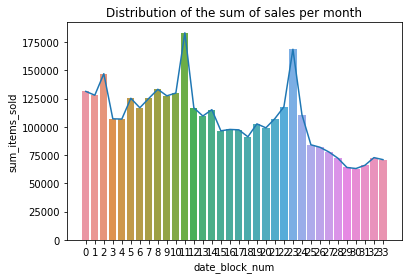

In [12]:
train_sales_month = pd.DataFrame(train.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
train_sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=train_sales_month.reset_index());
plt.plot(train_sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')

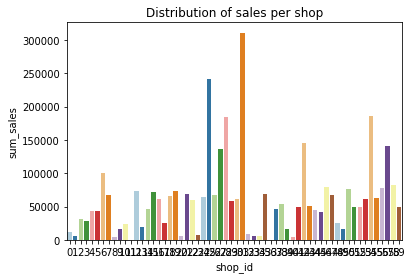

In [13]:
train_sales_month_shop_id = pd.DataFrame(train.groupby(['shop_id']).sum().item_cnt_day).reset_index()
train_sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=train_sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');

In [14]:
test.head(10)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


Lets try to plot shop_id vs item_id and see ther result

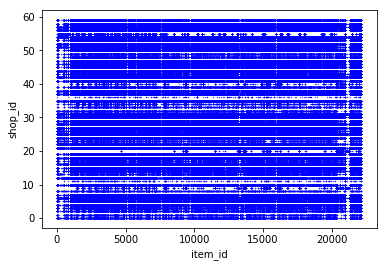

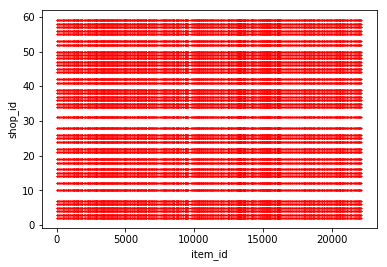

In [15]:
train.plot.scatter('item_id', 'shop_id', color='Blue', s = 0.1)
test.plot.scatter('item_id', 'shop_id', color='Red', s = 0.1)

So we see from the above figures, some shop_id  and item_id combination do not exist in the test case. 

In [16]:
test.merge(train, how='left', on=['shop_id', 'item_id']).isnull().sum()


ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
date_formatted    102796
day               102796
month             102796
year              102796
sales             102796
dtype: int64

1. Almost 50% of the data is not in test set (102796*2 = 205592). 

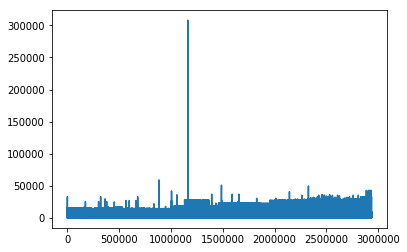

In [17]:
train.item_price.plot()

We have found an outlier and we will check if it is in the test data or not

In [18]:
train[train['item_price'] > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,sales
1163158,13.12.2013,11,12,6066,307980.0,1.0,2013-12-13,13,12,2013,307980.0


In [19]:
test[test['item_id']==6066].sum()


ID         0
shop_id    0
item_id    0
dtype: int64

similarly we check for the item_cnt_day

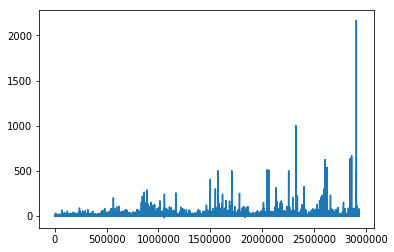

In [20]:
train.item_cnt_day.plot()

In [21]:
train[train['item_cnt_day'] > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,sales
2326930,15.01.2015,24,12,20949,4.000000,1000.0,2015-01-15,15,01,2015,4000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0,2015-10-28,28,10,2015,1971.0


In [22]:
test[test['item_id']==20949] 

,ID,shop_id,item_id
460,460,5,20949
5560,5560,4,20949
10660,10660,6,20949
15760,15760,3,20949
20860,20860,2,20949
25960,25960,7,20949
31060,31060,10,20949
36160,36160,12,20949
41260,41260,28,20949
46360,46360,31,20949


In [23]:
test[test['item_id']==11373]

,ID,shop_id,item_id
1596,1596,5,11373
6696,6696,4,11373
11796,11796,6,11373
16896,16896,3,11373
21996,21996,2,11373
27096,27096,7,11373
32196,32196,10,11373
37296,37296,12,11373
42396,42396,28,11373
47496,47496,31,11373


Ok so we can only eliminate the higher priced outlier but not the item_cnt_day as it occurs in the public test set. So, we take care of that[](http://)

In [24]:
train = train[train.item_price<100000]

### Trends
As with most ecommerce datasets, we see sales spike around Christmas and New Years every year.

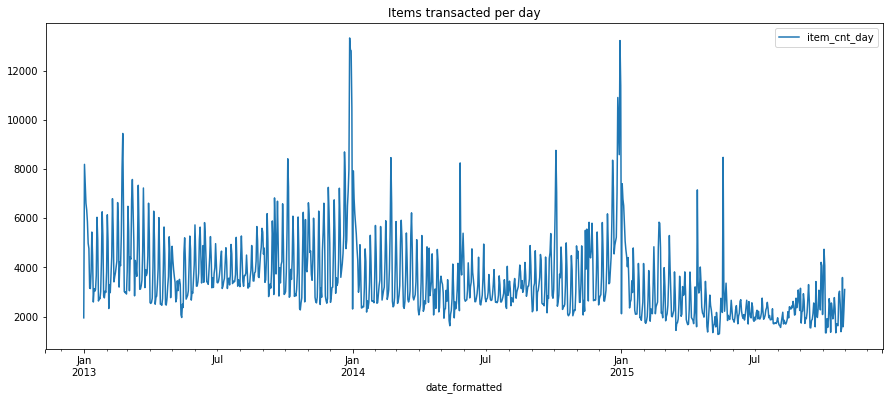

In [25]:
train.groupby('date_formatted').agg({"item_cnt_day": "sum"}).plot(figsize=(15,6),title="Items transacted per day")

Let's see if the decline each year is due to the rate of transactions or the count of items each day

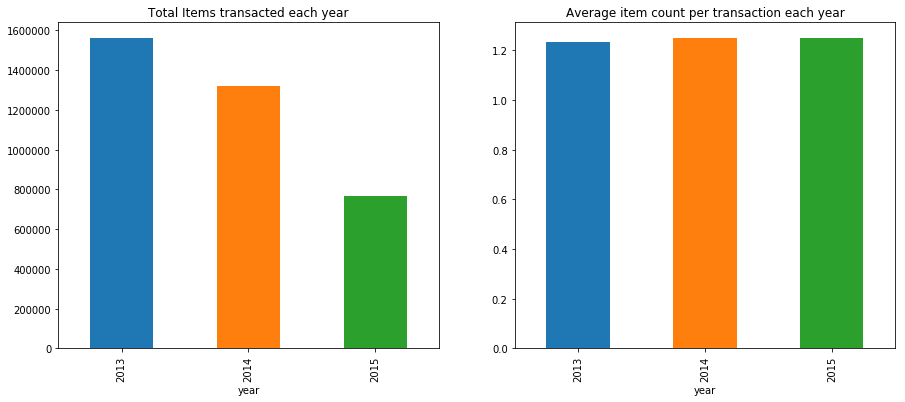

In [26]:
fig, axes = plt.subplots(1,2, figsize=(33,5))

train.groupby('year').item_cnt_day.sum().plot.bar(figsize=(15,6),title="Total Items transacted each year", ax=axes[0])
train.groupby('year').item_cnt_day.mean().plot.bar(figsize=(15,6),title="Average item count per transaction each year", ax=axes[1])

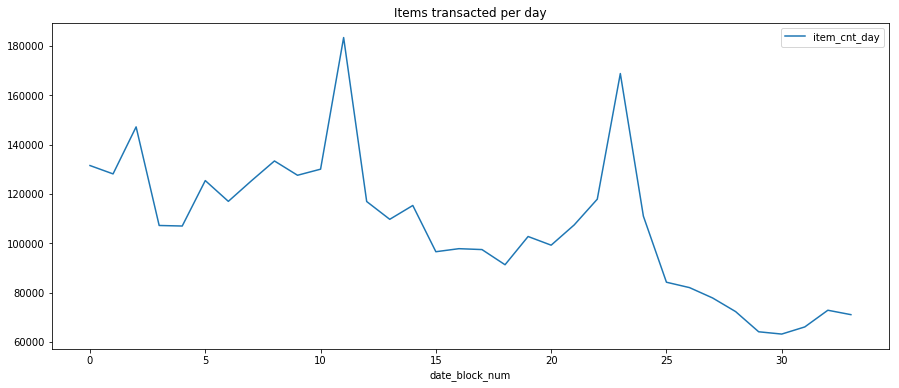

In [27]:
train.groupby('date_block_num').agg({"item_cnt_day": "sum"}).plot(figsize=(15,6),title="Items transacted per day")

### Weekly Seasonality
we can clearly see a rise in sales on Friday-Sunday

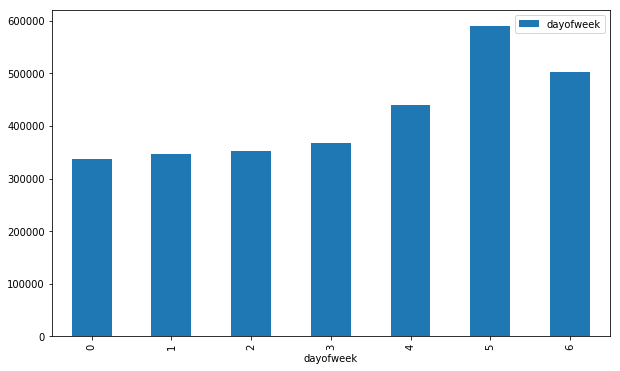

In [28]:
train['dayofweek'] = train.date_formatted.dt.dayofweek # The day of the week with Monday=0, Sunday=6
train.groupby("dayofweek").agg({"dayofweek": "count"}).plot.bar(figsize=(10, 6));

[Text(0,0.5,'sum item_cnt_day'), Text(0.5,0,'date month')]

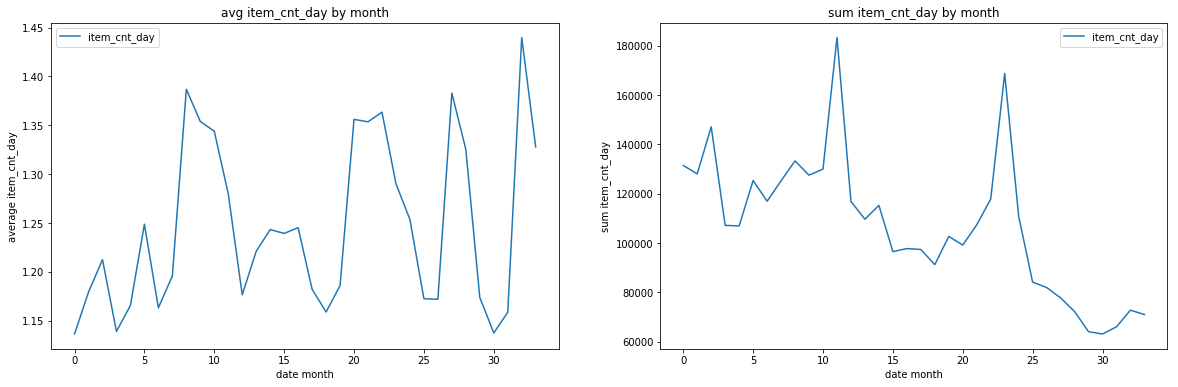

In [29]:
train['date_month'] = (train.year + train.month)
fig, axes = plt.subplots(1,2, figsize=(25,5))
ax = train.groupby('date_month').item_cnt_day.mean().reset_index().plot(x_compat=True,title="avg item_cnt_day by month", figsize=(20,6), ax=axes[0])
ax.set(xlabel='date month', ylabel='average item_cnt_day')

ax = train.groupby('date_month').item_cnt_day.sum().reset_index().plot(x_compat=True,title="sum item_cnt_day by month", figsize=(20,6), ax=axes[1])
ax.set(xlabel='date month', ylabel='sum item_cnt_day')

****

### Analysing date block number

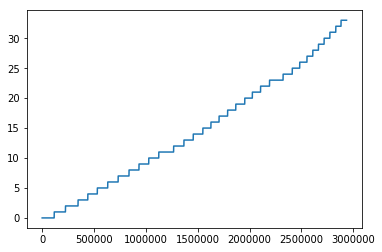

In [30]:
train.date_block_num.plot()

All of the date block num are equally distributed

### Prediction and manipulation of data


In [31]:
transactions = pd.merge(train, items, on='item_id', how='left')
transactions = transactions.drop('item_name', axis=1)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_formatted,day,month,year,sales,dayofweek,date_month,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-02,02,01,2013,999.00,2,201301,37
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-03,03,01,2013,899.00,3,201301,58
2,05.01.2013,0,25,2552,899.00,-1.0,2013-01-05,05,01,2013,-899.00,5,201301,58
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-06,06,01,2013,1709.05,6,201301,58
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-15,15,01,2013,1099.00,1,201301,56


In [32]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

The above grid dataframe has been developed to contain only the unique values from date_block_num, shop_id and item_id. Next we will generate mean encodings. For that we aggregate the sum of item_cnt_day and mean of item_cnt_price. We merge this to the unique values of gird data. Using the suggestion of coursera we further create aggregate values of the same functions but this grouped by [tytpe_id,block_date_num] instead of ['date_block_num', 'shop_id', 'item_id'] and merge them together to get our final aggreagted mean encodings

### Mean encodings

In [33]:
mean_transactions = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
mean_transactions = pd.merge(grid,mean_transactions,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        
        mean_df = transactions.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        mean_transactions = pd.merge(mean_transactions, mean_df, on=['date_block_num',type_id], how='left')
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113


In [34]:
lag_variables  = list(mean_transactions.columns[7:])+['item_cnt_day']

In [35]:
lag_variables

['item_id_avg_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_avg_item_cnt_day',
 'shop_id_avg_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_avg_item_cnt_day',
 'item_category_id_avg_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_avg_item_cnt_day',
 'item_cnt_day']

delelting the transactions data to clean up some space

In [36]:
print("available RAM:", psutil.virtual_memory())

gc.collect()

print("available RAM:", psutil.virtual_memory())

available RAM: svmem(total=27401117696, available=21743865856, percent=20.6, used=4995571712, free=11354959872, active=8535261184, inactive=6937747456, buffers=1071030272, cached=9979555840, shared=233738240, slab=443879424)
available RAM: svmem(total=27401117696, available=21743882240, percent=20.6, used=4995538944, free=11354959872, active=8535261184, inactive=6937763840, buffers=1071034368, cached=9979584512, shared=233738240, slab=443879424)


In [37]:
del transactions
del grid

We will add lag values to the functions

In [38]:
lags = [ 1, 2, 4, 7 ]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_4,item_id_sum_item_cnt_day_lag_4,item_id_avg_item_cnt_day_lag_4,shop_id_avg_item_price_lag_4,shop_id_sum_item_cnt_day_lag_4,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_7,item_id_sum_item_cnt_day_lag_7,item_id_avg_item_cnt_day_lag_7,shop_id_avg_item_price_lag_7,shop_id_sum_item_cnt_day_lag_7,shop_id_avg_item_cnt_day_lag_7,item_category_id_avg_item_price_lag_7,item_category_id_sum_item_cnt_day_lag_7,item_category_id_avg_item_cnt_day_lag_7,item_cnt_day_lag_7
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Removing the NANs

In [39]:
for feat in mean_transactions.columns:
    if 'item_cnt' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(0)
    elif 'item_price' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(mean_transactions[feat].median())

In [40]:
del sales_new_df

In [41]:
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_4,item_id_sum_item_cnt_day_lag_4,item_id_avg_item_cnt_day_lag_4,shop_id_avg_item_price_lag_4,shop_id_sum_item_cnt_day_lag_4,shop_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_id_avg_item_price_lag_7,item_id_sum_item_cnt_day_lag_7,item_id_avg_item_cnt_day_lag_7,shop_id_avg_item_price_lag_7,shop_id_sum_item_cnt_day_lag_7,shop_id_avg_item_cnt_day_lag_7,item_category_id_avg_item_price_lag_7,item_category_id_sum_item_cnt_day_lag_7,item_category_id_avg_item_cnt_day_lag_7,item_cnt_day_lag_7
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414,299.0,0.0,0.0,881.045234,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,874.185765,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,862.098822,0.0,0.0,375.982848,0.0,0.0,0.0,299.0,0.0,0.0,843.215471,0.0,0.0,375.982848,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595,299.0,0.0,0.0,881.045234,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,874.185765,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,862.098822,0.0,0.0,375.982848,0.0,0.0,0.0,299.0,0.0,0.0,843.215471,0.0,0.0,375.982848,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595,299.0,0.0,0.0,881.045234,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,874.185765,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,862.098822,0.0,0.0,375.982848,0.0,0.0,0.0,299.0,0.0,0.0,843.215471,0.0,0.0,375.982848,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519,299.0,0.0,0.0,881.045234,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,874.185765,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,862.098822,0.0,0.0,375.982848,0.0,0.0,0.0,299.0,0.0,0.0,843.215471,0.0,0.0,375.982848,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113,299.0,0.0,0.0,881.045234,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,874.185765,0.0,0.0,379.19881,0.0,0.0,0.0,299.0,0.0,0.0,862.098822,0.0,0.0,375.982848,0.0,0.0,0.0,299.0,0.0,0.0,843.215471,0.0,0.0,375.982848,0.0,0.0,0.0


dropping non-lagged columsn except item_cnt_day as it is the target

In [42]:
cols_to_drop = lag_variables[:-1] + ['item_name'] +['item_price']# dropping all target variables but not "item_cnt_day" cause is target
training = mean_transactions.drop(cols_to_drop,axis=1)

Removing the cells with dateblcok less than 12 ( the maximum lag month )

In [43]:
training = training[training['date_block_num']>12]

In [44]:
#X_train = training[training['date_block_num']<33]
#X_cv =  training[training['date_block_num']==33]
#X_test = training[training['date_block_num']==34]

In [45]:
#X_train['item_cnt_day'].clip_upper(40, inplace=True)
#X_train['item_cnt_day'].clip_lower(0, inplace=True)

#X_cv['item_cnt_day'].clip_upper(40, inplace=True)
#X_cv['item_cnt_day'].clip_lower(0, inplace=True)

#X_test['item_cnt_day'].clip_upper(40, inplace=True)
#X_test['item_cnt_day'].clip_lower(0, inplace=True)

#x1 = X_train.drop(columns=['date_block_num'])
#x2 = X_cv.drop(columns=['date_block_num'])
#xtrain = x1.iloc[:, x1.columns != 'item_cnt_day'].values
#ytrain = x1.iloc[:, x1.columns == 'item_cnt_day'].values
#xcv = x2.iloc[:, x1.columns != 'item_cnt_day'].values
#ycv = x2.iloc[:, x1.columns == 'item_cnt_day'].values

**Manipulating the test data**

In [46]:
test['date_block_num'] = 34
test = pd.merge(test, items, on='item_id', how='left')
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')



In [47]:
del mean_transactions
del sales_new_df

In [48]:
gc.collect()

222

In [49]:
_test = set(test.drop(['ID', 'item_name','date_block_num'], axis=1).columns)
_training = set(training.drop(['item_cnt_day','date_block_num'],axis=1).columns)
for i in _test:
    assert i in _training
for i in _training:
    assert i in _test # to assert equal columns in training and test set
assert _training == _test

In [50]:
del _test
del _training
gc.collect()

0

In [51]:
test = test.drop(['ID', 'item_name'], axis=1)
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat]=test[feat].fillna(test[feat].median())

In [52]:
test.drop(columns='date_block_num').columns

Index(['shop_id', 'item_id', 'item_category_id',
       'item_id_avg_item_price_lag_1', 'item_id_sum_item_cnt_day_lag_1',
       'item_id_avg_item_cnt_day_lag_1', 'shop_id_avg_item_price_lag_1',
       'shop_id_sum_item_cnt_day_lag_1', 'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2',
       'item_id_avg_item_price_lag_4', 'item_id_sum_item_cnt_day_lag_4',
       'item_id_avg_item_cnt_day_lag_4', 'shop_id_avg_item_price_lag_4',
       'shop_id_sum_ite

**Generating the data as output for computing later**

In [53]:
dftest = pd.DataFrame(test)
dftrain = pd.DataFrame(training)

In [54]:
dftest.to_csv('dftest.csv', index = False)
dftrain.to_csv('dftrain.csv', index = False)